In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import os.path 
import tqdm

In [2]:
import sys
d2_net_path = "/home/mikhail/research/d2-net/lib"
d2_net_path_lib = "/home/mikhail/research/d2-net"
if d2_net_path not in sys.path:
    sys.path.append(d2_net_path)
if d2_net_path_lib not in sys.path:
    sys.path.append(d2_net_path_lib)
from pyramid import process_multiscale
from model_test import D2Net
from utils import preprocess_image

In [3]:
from pyro.nn import AutoRegressiveNN
from pyro import distributions
import pyro

# Predict features

In [4]:
MODEL_FILE = "/home/mikhail/research/d2-net/models/d2_ots.pth"
DATASET_PATH = "data/7scenes/fire"
ROOT_PATH = "/home/mikhail/research/unsup-3d-keypoints"

In [5]:
MODEL = D2Net(
    model_file=MODEL_FILE,
    use_relu=True,
    use_cuda=True
)
IMAGE_PATH = "/media/mikhail/Data3T/7scenes/fire/seq-01/frame-000001.color.png"
INPUT_IMAGE = np.asarray(Image.open(IMAGE_PATH))
IMAGE_TENSOR = preprocess_image(INPUT_IMAGE, preprocessing="torch")[None]
IMAGE_TENSOR = torch.tensor(IMAGE_TENSOR).float().cuda()
IMAGE_TENSOR.size()
with torch.no_grad():
    keypoints, scores, descriptors = process_multiscale(IMAGE_TENSOR, MODEL, scales=[1])

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


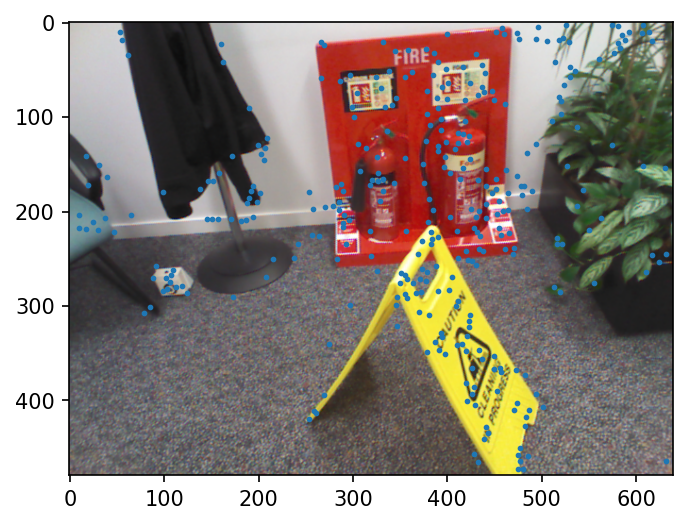

In [250]:
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
mask = scores > 15
plt.scatter(keypoints[mask, 1], keypoints[mask, 0], s=3)

In [251]:
masked_keypoints = keypoints[mask, :2]
masked_descriptors = descriptors[mask]
mean = np.mean(masked_keypoints, axis=0)
std = np.std(masked_keypoints, axis=0)
transformed_keypoints = (masked_keypoints - mean) / std

# Keypoint network

In [206]:
class KeypointNetwork(nn.Module):
    def __init__(self, input_dimension, hidden_dimensions, output_dimension=2):
        super().__init__()
        self.backend = self.make_backend(input_dimension, hidden_dimensions, output_dimension)

    @staticmethod
    def make_backend(input_dimension, hidden_dimensions, output_dimension=2):
        modules = []
        input_dimension = input_dimension
        for dimension in hidden_dimensions:
            modules.append(nn.Linear(input_dimension, dimension))
            input_dimension = dimension
            modules.append(nn.ReLU())
        modules.append(nn.Linear(input_dimension, output_dimension))
        return nn.Sequential(*modules)
    
    def forward(self, x):
        return self.backend(x)

In [211]:
model = KeypointNetwork(512, (64,)).cuda()
loss_function = nn.HuberLoss(delta=10)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 1e-1)
input_data = torch.tensor(masked_descriptors.astype(np.float32)).cuda()
output_data = torch.tensor(transformed_keypoints[:, :2].astype(np.float32)).cuda()
losses = []
iteration_count = 20000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted = model(input_data)
    loss = loss_function(predicted, output_data)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    

100%|████████████████████████████████████| 20000/20000 [00:23<00:00, 835.02it/s]


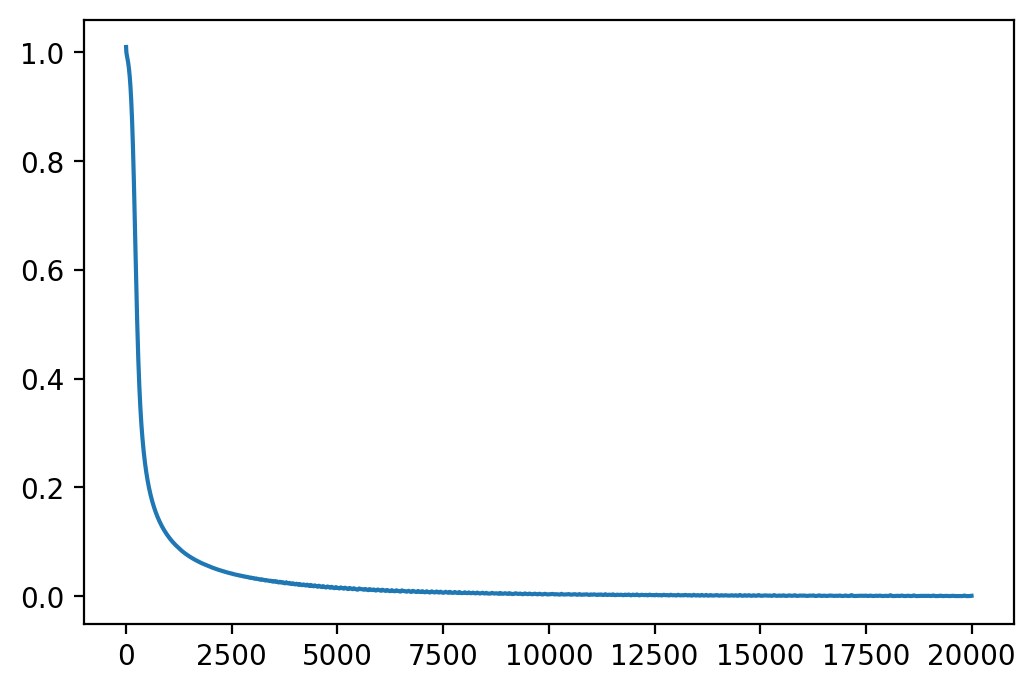

In [214]:
plt.figure(dpi=200)
plt.plot(losses)

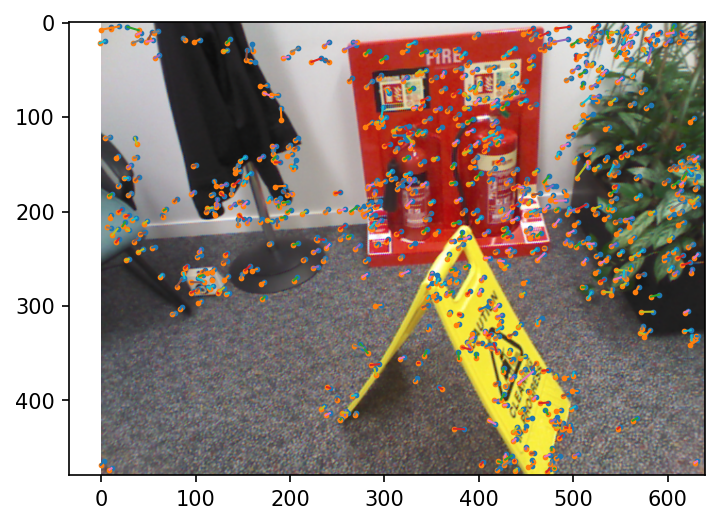

In [215]:
predicted_keypoints = predicted.cpu().detach().numpy() * std + mean
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
plt.scatter(masked_keypoints[:, 1], masked_keypoints[:, 0], s=3)
plt.scatter(predicted_keypoints[:, 1], predicted_keypoints[:, 0], s=3)
for i in range(len(masked_keypoints)):
    plt.plot([masked_keypoints[i, 1], predicted_keypoints[i, 1]], 
             [masked_keypoints[i, 0], predicted_keypoints[i, 0]], linewidth=1)

In [217]:
losses[-1]

0.0008749141125008464

# Deformable lattice

In [295]:
class DeformableLattice(nn.Module):
    def __init__(self, input_dimension, hidden_dimensions, autoregressive_dimensions, 
                 count_degree=6, count_sum=3, classification_dimension=2):
        super().__init__()
        self.classifier = KeypointNetwork(input_dimension, hidden_dimensions, classification_dimension)
        autoregressive = AutoRegressiveNN(2, autoregressive_dimensions, 
                                               nonlinearity=nn.LeakyReLU())
        self.transform = distributions.transforms.AffineAutoregressive(autoregressive)

    def forward(self, x):
        x = self.classifier(x)
        probability = torch.sigmoid(x)
        
        transformed_probability = (probability * 32 - torch.floor(probability * 32)).detach()
        a = torch.bernoulli(transformed_probability).detach()
        c = (a - transformed_probability).detach()
        x = c / 32. + probability
        x = 2 * x - 1
        return self.transform(x)
        
    @staticmethod
    def integer_from_bernuli(x):
        two_powers =  2. ** (torch.linspace(0., -x.shape[1] + 1., x.shape[1]).to(x.device))
        return torch.sum((2 * x - 1) * two_powers[None, :], dim=1)

In [296]:
model = DeformableLattice(512, (64,), [64, 64]).cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 1e-1)
input_data = torch.tensor(masked_descriptors.astype(np.float32)).cuda()
output_data = torch.tensor(transformed_keypoints[:, :2].astype(np.float32)).cuda()
losses = []
iteration_count = 20000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted = model(input_data)
    loss = loss_function(predicted, output_data)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    

100%|████████████████████████████████████| 20000/20000 [00:59<00:00, 338.75it/s]


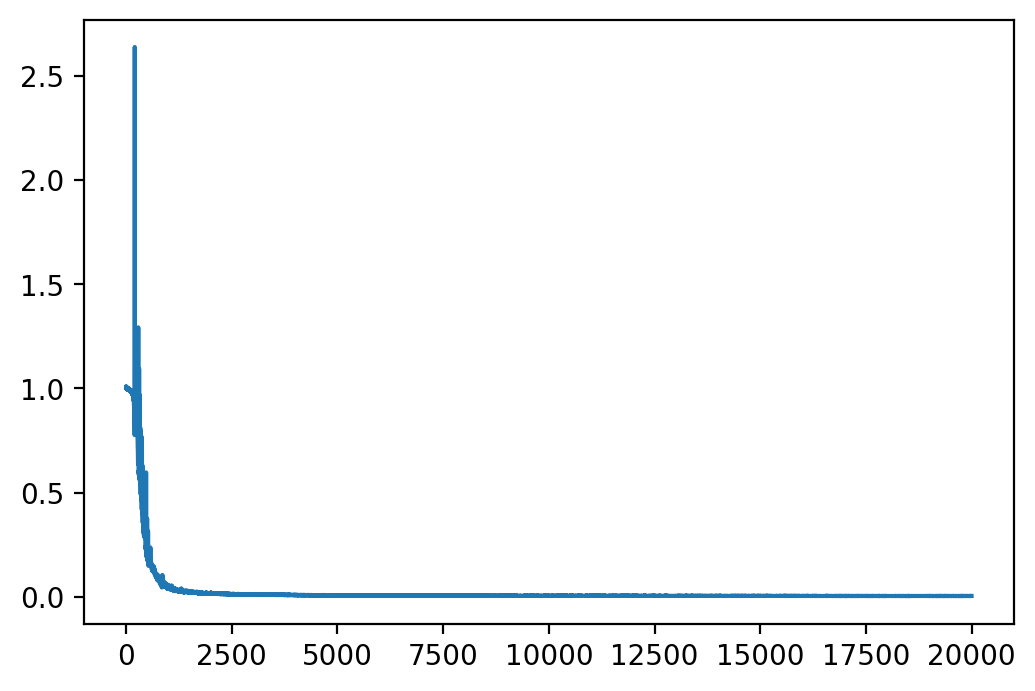

In [297]:
plt.figure(dpi=200)
plt.plot(losses)

In [298]:
x = torch.sigmoid(model.classifier(input_data)) * 32
dx = x - torch.floor(x)
torch.mean(torch.abs(dx - 0.5))

tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)

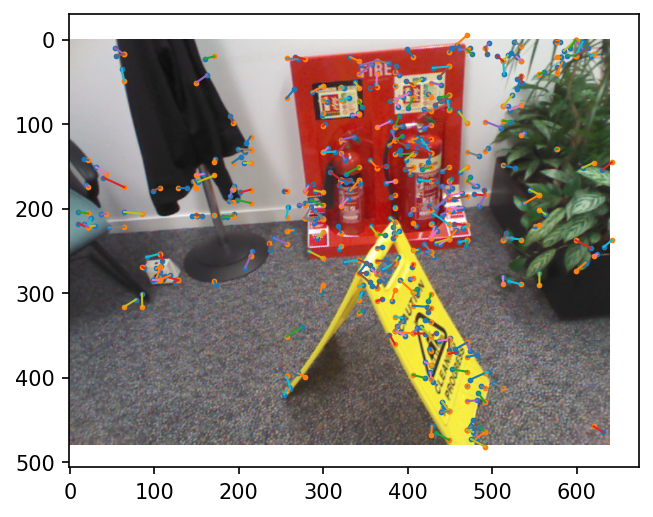

In [299]:
predicted_keypoints = predicted.cpu().detach().numpy() * std + mean
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
plt.scatter(masked_keypoints[:, 1], masked_keypoints[:, 0], s=3)
plt.scatter(predicted_keypoints[:, 1], predicted_keypoints[:, 0], s=3)
for i in range(len(masked_keypoints)):
    plt.plot([masked_keypoints[i, 1], predicted_keypoints[i, 1]], 
             [masked_keypoints[i, 0], predicted_keypoints[i, 0]], linewidth=1)

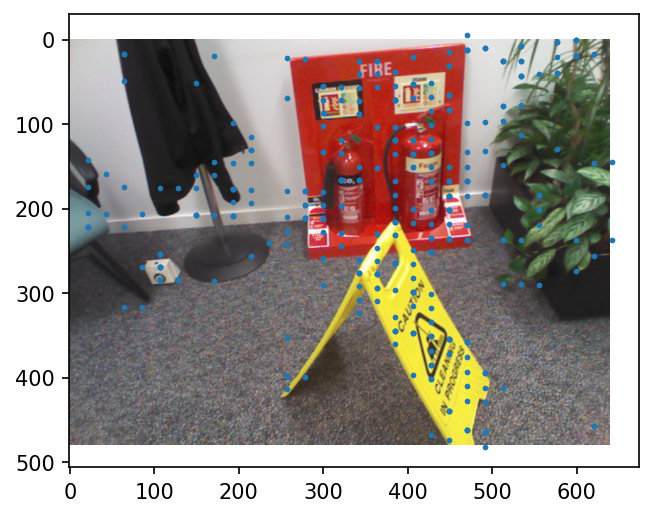

In [300]:
predicted_keypoints = predicted.cpu().detach().numpy() * std + mean
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
plt.scatter(predicted_keypoints[:, 1], predicted_keypoints[:, 0], s=3)

In [301]:
losses[-1]

0.003860289230942726

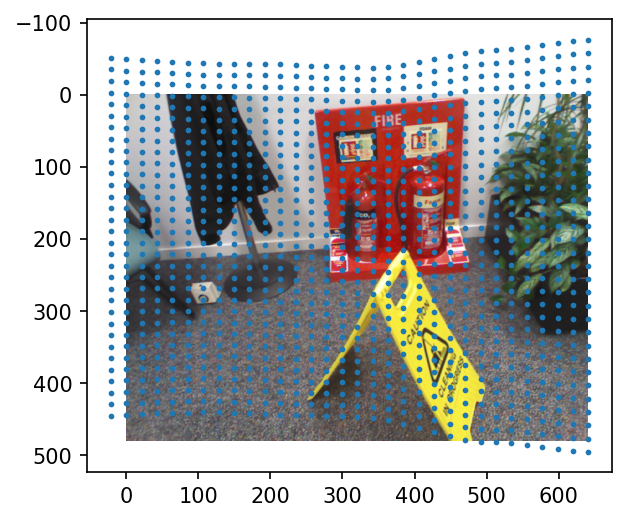

In [302]:
x, y = np.meshgrid(np.linspace(-1, 1 - 1 / 16., 32, dtype=np.float32), np.linspace(-1, 1 - 1 / 16., 32, np.float32))
points = np.array([x.flatten(), y.flatten()]).T.astype(np.float32)
predicted_keypoints = model.transform(torch.tensor(points).cuda()).cpu().detach().numpy() * std + mean
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
plt.scatter(predicted_keypoints[:, 1], predicted_keypoints[:, 0], s=3)